In [24]:
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [26]:
from pyspark.sql import SparkSession

# Create a spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .getOrCreate()
)

# 1.Read the data in and check the presence of null value

In [27]:
# function used to check the presence of null values.
def check_null_value(dataframe):
    for columns in dataframe.columns:
        print('Number of null value in', columns, ':', dataframe.where(F.col(columns).isNull()).count())
    return

In [28]:
consumer_id = spark.read.parquet('../data/tables/consumer_user_details.parquet')
check_null_value(consumer_id)

Number of null value in user_id : 0
Number of null value in consumer_id : 0


In [29]:
# Use pandas read consumer csv
raw_consumer_df = spark.read.option("header",True).csv('../data/tables/tbl_consumer.csv')
check_null_value(raw_consumer_df)

Number of null value in name : 0
Number of null value in address : 0
Number of null value in state : 0
Number of null value in postcode : 0
Number of null value in gender : 0
Number of null value in consumer_id : 0


In [30]:
merchant_df = spark.read.parquet('../data/tables/tbl_merchants.parquet').withColumnRenamed('name','merchant_name')
check_null_value(merchant_df)

Number of null value in merchant_name : 0
Number of null value in tags : 0
Number of null value in merchant_abn : 0


In [31]:
path_list = []
period1 = pd.date_range('2021-2-28','2021-08-27', freq='D').strftime("%Y-%m-%d").tolist()
period2 = pd.date_range('2021-8-28','2022-02-27', freq='D').strftime("%Y-%m-%d").tolist()
period3 = pd.date_range('2022-2-28','2022-08-28', freq='D').strftime("%Y-%m-%d").tolist()
path_prefix1 = '../data/tables/transactions_20210228_20210827_snapshot/order_datetime='
path_prefix2 = '../data/tables/transactions_20210828_20220227_snapshot/order_datetime='
path_prefix3 = '../data/tables/transactions_20220228_20220828_snapshot/order_datetime='
for date in period1:
    path_list.append(path_prefix1 + date)
for date in period2:
    path_list.append(path_prefix2 + date)
for date in period3:
    path_list.append(path_prefix3 + date)

raw_transactions_df = spark.read.parquet(*path_list)

check_null_value(raw_transactions_df)

Number of null value in user_id : 0


Number of null value in merchant_abn : 0


Number of null value in dollar_value : 0


Number of null value in order_id : 0


#### No null value is found in the raw datasets.

# 2. Data aggregation

First, we aggregate the given consumer, merchant and transactions data, drop the irrelevant features for the ranking system such as consumers' id and name, transactions' order id and merchants' abn.

In [32]:
consumer_df =  consumer_id.join(raw_consumer_df, consumer_id.consumer_id == raw_consumer_df.consumer_id, 'inner')\
                            .withColumnRenamed('name','consumer_name')\
                            .withColumnRenamed('address','consumer_address')

Get the take rate of each merchant.

In [33]:
merchant_df = merchant_df.withColumn('tags_string', split(merchant_df['tags'], ':'))\
                         .withColumn('rate_string', element_at(col('tags_string'), -1))\
                         .withColumn('rate_substring', substring('rate_string', 1, 5))\
                         .withColumn('take_rate', col('rate_substring').cast('double'))\
                         .drop('rate_string', 'rate_substring', 'tags_string')

In [34]:
transactions_df = raw_transactions_df.join(merchant_df, raw_transactions_df.merchant_abn == merchant_df.merchant_abn, 'inner')\
                           .join(consumer_df, raw_transactions_df.user_id == consumer_df.user_id, 'inner')\
                           .drop('merchant_abn', 'order_id', 'user_id', 'consumer_id', 'consumer_name')

In [35]:
raw_transactions_df.count(), transactions_df.count()

(12561377, 12047317)

Since some merchant abns from the transaction data do not match with any merchant from the merchant, we should remove them by inner join with the merchant dataset. About  5% of data are eliminated.

In [47]:
transactions_df.limit(10)

dollar_value,merchant_name,tags,take_rate,consumer_address,state,postcode,gender
226.70111326425848,Orci Ltd,[(digital goods: ...,2.19,122 Brandon Cliff,QLD,4606,Female
746.641542887258,Metus Aenean Indu...,[[music shops - m...,3.21,122 Brandon Cliff,QLD,4606,Female
28.69248621050033,Praesent Eu Assoc...,([tent and awning...,2.5,122 Brandon Cliff,QLD,4606,Female
1477.9174337803072,Nam Ligula Elit F...,([lawn and garden...,3.58,122 Brandon Cliff,QLD,4606,Female
93.96901941736229,Nec Ante Ltd,"((cable, satellit...",5.61,122 Brandon Cliff,QLD,4606,Female
13.923908403587916,Donec Sollicitudi...,"[[watch, clock, a...",5.93,122 Brandon Cliff,QLD,4606,Female
92.43454448910457,Nullam Enim Ltd,"([computers, comp...",3.22,122 Brandon Cliff,QLD,4606,Female
96.08515812536056,Dictum Phasellus ...,"[(gift, card, nov...",5.65,122 Brandon Cliff,QLD,4606,Female
24.606053328805864,Ac Institute,"([watcH, clock, a...",2.62,122 Brandon Cliff,QLD,4606,Female
29.06062645242927,Erat Vitae LLP,[(florists suppli...,2.94,122 Brandon Cliff,QLD,4606,Female


We compute the total income, the number of transactions, the mean transaction amount and the profit for each merchant for the preliminary analysis.

In [50]:
merchant_detail = transactions_df.groupBy('merchant_name', 'tags', 'take_rate')\
                  .agg(
                       F.round(F.sum('dollar_value'),2).alias('total_income'),
                       F.count('merchant_name').alias('total_transactions'), )\
                  .withColumn('mean_transaction_amount',  F.round(F.col('total_income')/F.col('total_transactions')))\
                  .withColumn('monthly_profit',  F.round(F.col('total_income')*F.col('take_rate')/100/18))\
                  .orderBy('monthly_profit', ascending = False)

In [51]:
merchant_detail.toPandas()

,merchant_name,tags,take_rate,total_income,total_transactions,mean_transaction_amount,monthly_profit
0,Amet Risus Inc.,"([furniture, home furnishings and equipment sh...",6.82,8657277.10,4251,2037.0,32801.0
1,Dignissim Maecenas Foundation,"[[opticians, oPtical goods, and eyeglasses], [...",6.64,8316735.67,58685,142.0,30680.0
2,Orci In Consequat Corporation,"([gift, card, novelty, and souvenir shops], [a...",6.61,8339994.52,75853,110.0,30626.0
3,Leo In Consulting,"[[watch, clock, and jewelry repair shops], [a]...",6.43,8443178.70,241336,35.0,30161.0
4,Etiam Bibendum Industries,"[(tent and awning shops), (a), (take rate: 6.31)]",6.31,8482176.66,6341,1338.0,29735.0
...,...,...,...,...,...,...,...
4021,Feugiat Nec Diam LLC,"([computers, computer peripheral equipment, an...",0.30,18710.78,703,27.0,3.0
4022,Proin Vel Inc.,"[[stationery, office supplies and printing and...",0.16,21967.78,31,709.0,2.0
4023,Hendrerit Donec Limited,"[(digital goods: books, movies, music), (e), (...",0.18,20034.94,590,34.0,2.0
4024,Turpis Incorporated,"[[gift, card, novelty, and souvenir shops], [e...",0.23,16159.06,156,104.0,2.0


In [52]:
merchant_detail.orderBy('total_transactions', ascending = False).toPandas()

,merchant_name,tags,take_rate,total_income,total_transactions,mean_transaction_amount,monthly_profit
0,Erat Vitae LLP,"[(florists supplies, nursery stock, and floWer...",2.94,7694482.39,256062,30.0,12568.0
1,Leo In Consulting,"[[watch, clock, and jewelry repair shops], [a]...",6.43,8443178.70,241336,35.0,30161.0
2,Pede Nonummy Corp.,"((tent and awning shops), (c), (take rate: 2.86))",2.86,6679660.18,230845,29.0,10613.0
3,Non Vestibulum Industries,"((teNt and awning shops), (a), (take rate: 5.80))",5.80,6341522.13,218852,29.0,20434.0
4,Suspendisse Dui Corporation,"((opticians, optical goods, and eyeglasses), (...",2.93,6221893.45,207410,30.0,10128.0
...,...,...,...,...,...,...,...
4021,Tempor Augue Ac Company,"[(jewelry, watch, clock, and silverware shops)...",2.18,2429.91,1,2430.0,3.0
4022,Egestas Nunc Sed LLC,"[[antique shops - sales, repairs, and restorat...",4.93,22835.12,1,22835.0,63.0
4023,Phasellus LLP,"[(antique shops - sales, repairs, and resToraT...",3.28,36950.79,1,36951.0,67.0
4024,Aliquam Eu Institute,"[[anTique shops - sales, repairs, and restorat...",6.99,38089.94,1,38090.0,148.0


In [53]:
merchant_detail.orderBy('mean_transaction_amount', ascending = False).toPandas()

,merchant_name,tags,take_rate,total_income,total_transactions,mean_transaction_amount,monthly_profit
0,Elit Dictum Eu Foundation,"((art dealers and galleries), (a), (take rate:...",6.40,51876.64,1,51877.0,184.0
1,Aenean Gravida Institute,"((antique shops - sales, repairs, and restorat...",1.54,40896.26,1,40896.0,35.0
2,Aliquam Eu Institute,"[[anTique shops - sales, repairs, and restorat...",6.99,38089.94,1,38090.0,148.0
3,Phasellus LLP,"[(antique shops - sales, repairs, and resToraT...",3.28,36950.79,1,36951.0,67.0
4,Dictum Mi Corporation,"[(antique shops - sales, repairs, and restorat...",3.00,53473.35,2,26737.0,89.0
...,...,...,...,...,...,...,...
4021,Urna Nullam Lobortis Institute,"((tent and awning shops), (b), (take rate: 3.48))",3.48,15488.95,1123,14.0,30.0
4022,Malesuada Fringilla Est Institute,"[(tent and Awning shops), (a), (take rate: 5....",5.96,21729.71,1655,13.0,72.0
4023,Egestas Rhoncus Proin Inc.,"[(tEnt and awning shops), (b), (take rate: 4.08)]",4.08,131765.63,9842,13.0,299.0
4024,Eros Limited,"[[digital goods: books, movies, music], [c], [...",2.52,544031.81,48290,11.0,762.0


In [54]:
merchant_detail.count(), merchant_df.count()

(4026, 4026)

In [55]:
# Save the preprocessed data
transactions_df.write.mode('overwrite').parquet('../data/curated/transactions_detail.parquet')
merchant_detail.write.mode('overwrite').parquet('../data/curated/merchant_detail.parquet')

22/09/11 20:23:42 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
22/09/11 20:23:42 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
22/09/11 20:23:58 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


22/09/11 20:23:59 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


# 3. Preliminarily check distribution of data

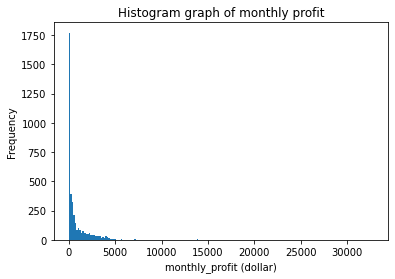

In [56]:
bins, counts = merchant_detail.select('monthly_profit').rdd.flatMap(lambda x: x).histogram(200)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.ylabel('Frequency')
plt.xlabel('monthly_profit (dollar)')
plt.title('Histogram graph of monthly profit')
plt.savefig('../plots/Histogram graph of monthly profit')
plt.show()

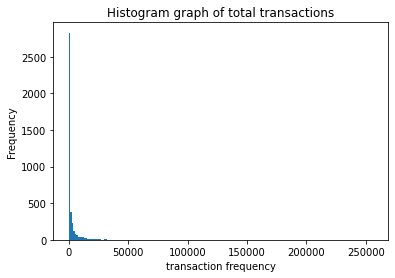

In [57]:
bins, counts = merchant_detail.select('total_transactions').rdd.flatMap(lambda x: x).histogram(200)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.ylabel('Frequency')
plt.xlabel('transaction frequency')
plt.title('Histogram graph of total transactions')
plt.savefig('../plots/Histogram graph of total transactions')
plt.show()

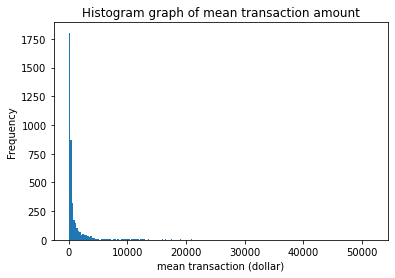

In [58]:
bins, counts = merchant_detail.select('mean_transaction_amount').rdd.flatMap(lambda x: x).histogram(200)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.ylabel('Frequency')
plt.xlabel('mean transaction (dollar)')
plt.title('Histogram graph of mean transaction amount')
plt.savefig('../plots/Histogram graph of mean transaction amount')
plt.show()

There are some extremely large values, outliers elimination and data transformation may be needed.